### Importazione librerie

In [97]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Function per backtest

In [98]:
# Parametri fissi
COMMISSION_RATE = 0.0002  # 0.02% su entry e exit
MAX_POSITION_VALUE = 2_000_000  # USDT
MMR = 0.005  # 0.5%
MAINTENANCE_MARGIN_DEDUCTION = 0  # Modificabile

In [99]:
# Funzione per calcolare metriche dall'order book
def calculate_metrics(df):
    """Calcola indicatori basati sui dati dell'order book."""
    df = df.copy()
    df['obi'] = (df['notional_-5'] - df['notional_5']) / (df['notional_-5'] + df['notional_5'])
    df['spread'] = (df['notional_1'] - df['notional_-1']) / df['close']
    return df

# Funzione per calcolare il max drawdown
def max_drawdown(portfolio_values):
    """Calcola il massimo drawdown in percentuale."""
    peak = portfolio_values.iloc[0]
    max_dd = 0
    for value in portfolio_values:
        peak = max(peak, value)
        drawdown = (peak - value) / peak if peak > 0 else 0  # Evita divisioni per zero
        max_dd = max(max_dd, drawdown)
    return max_dd * 100  # Drawdown massimo in percentuale

# Funzione di backtesting con take profit
def backtest_strategy(df, params, initial_balance=100, MAX_POSITION_VALUE=2_000_000):
    """Esegue il backtesting della strategia con gestione di posizioni, leva, commissioni, stop loss e take profit."""
    df = df.copy()
    
    # Inizializzazione delle colonne del DataFrame
    df['signal'] = 0  # 1: long, -1: short, 0: nessuna posizione
    df['portfolio'] = float(initial_balance)  # Capitale non impegnato
    df['unrealized_pnl'] = 0.0  # PnL non realizzato
    df['total_portfolio'] = float(initial_balance)  # Portafoglio totale (capitale + PnL non realizzato)
    df['returns'] = 0.0
    df['position_size'] = 0.0  # Dimensione posizione in BTC
    df['position_value'] = 0.0  # Valore posizione in USDT
    df['pnl'] = 0.0  # Profitto/Perdita per timestep
    df['commissions'] = 0.0  # Commissioni pagate

    # Stato della posizione
    position = {
        'direction': 0,  # 1: long, -1: short, 0: nessuna
        'size': 0.0,  # Quantità in BTC
        'entry_price': 0.0,
        'entry_idx': 0,
        'liquidation_price': 0.0,
        'take_profit_price': 0.0,  # Prezzo di take profit
        'stop_loss_price': 0.0,    # Prezzo di stop loss
        'entry_portfolio': 0.0     # Valore del portafoglio all'entrata
    }
    
    trade_history = []  # Lista per registrare i trade

    for i in range(len(df)):
        current_idx = df.index[i]
        
        # Propagazione del valore del portafoglio dal timestep precedente
        if i == 0:
            current_portfolio = initial_balance
        else:
            previous_idx = df.index[i-1]
            current_portfolio = df.at[previous_idx, 'portfolio']
        df.at[current_idx, 'portfolio'] = current_portfolio
        
        current = df.iloc[i]
        
        # Aggiorna PnL non realizzato se c'è una posizione aperta
        if position['size'] > 0:
            current_price = current['close']
            unrealized_pnl = position['size'] * position['direction'] * (current_price - position['entry_price'])
            df.at[current_idx, 'unrealized_pnl'] = unrealized_pnl
            df.at[current_idx, 'total_portfolio'] = current_portfolio + unrealized_pnl

            # Controllo stop loss
            if (position['direction'] == 1 and current['low'] <= position['stop_loss_price']) or \
               (position['direction'] == -1 and current['high'] >= position['stop_loss_price']):
                exit_price = position['stop_loss_price']
                pnl = position['size'] * position['direction'] * (exit_price - position['entry_price'])
                commission = position['size'] * exit_price * COMMISSION_RATE
                pnl -= commission
                
                # Registra il trade
                trade_history.append({
                    'entry_time': df.index[position['entry_idx']],
                    'exit_time': current_idx,
                    'direction': position['direction'],
                    'size': position['size'],
                    'entry_price': position['entry_price'],
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'commission': commission,
                    'reason': 'stop_loss',
                    'entry_portfolio': position['entry_portfolio'],
                    'exit_portfolio': df.at[current_idx, 'total_portfolio']
                })
                
                df.at[current_idx, 'pnl'] = pnl
                df.at[current_idx, 'commissions'] = commission
                new_portfolio = current_portfolio + pnl
                df.at[current_idx, 'portfolio'] = max(new_portfolio, 0)
                position = reset_position()
                df.at[current_idx, 'signal'] = 0
                df.at[current_idx, 'position_size'] = 0.0
                df.at[current_idx, 'position_value'] = 0.0
                df.at[current_idx, 'unrealized_pnl'] = 0.0
                df.at[current_idx, 'total_portfolio'] = max(new_portfolio, 0)
                continue

            # Controllo take profit
            if (position['direction'] == 1 and current['high'] >= position['take_profit_price']) or \
               (position['direction'] == -1 and current['low'] <= position['take_profit_price']):
                exit_price = position['take_profit_price']
                pnl = position['size'] * position['direction'] * (exit_price - position['entry_price'])
                commission = position['size'] * exit_price * COMMISSION_RATE
                pnl -= commission
                
                trade_history.append({
                    'entry_time': df.index[position['entry_idx']],
                    'exit_time': current_idx,
                    'direction': position['direction'],
                    'size': position['size'],
                    'entry_price': position['entry_price'],
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'commission': commission,
                    'reason': 'take_profit',
                    'entry_portfolio': position['entry_portfolio'],
                    'exit_portfolio': df.at[current_idx, 'total_portfolio']
                })
                
                df.at[current_idx, 'pnl'] = pnl
                df.at[current_idx, 'commissions'] = commission
                new_portfolio = current_portfolio + pnl
                df.at[current_idx, 'portfolio'] = max(new_portfolio, 0)
                position = reset_position()
                df.at[current_idx, 'signal'] = 0
                df.at[current_idx, 'position_size'] = 0.0
                df.at[current_idx, 'position_value'] = 0.0
                df.at[current_idx, 'unrealized_pnl'] = 0.0
                df.at[current_idx, 'total_portfolio'] = max(new_portfolio, 0)
                continue

        else:
            df.at[current_idx, 'unrealized_pnl'] = 0.0
            df.at[current_idx, 'total_portfolio'] = current_portfolio

        # Controllo liquidazione
        if position['size'] > 0:
            liq_price = position['liquidation_price']
            if (position['direction'] == 1 and current['low'] <= liq_price) or \
               (position['direction'] == -1 and current['high'] >= liq_price):
                exit_price = liq_price
                pnl = position['size'] * position['direction'] * (exit_price - position['entry_price'])
                commission = position['size'] * exit_price * COMMISSION_RATE
                pnl -= commission
                
                trade_history.append({
                    'entry_time': df.index[position['entry_idx']],
                    'exit_time': current_idx,
                    'direction': position['direction'],
                    'size': position['size'],
                    'entry_price': position['entry_price'],
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'commission': commission,
                    'reason': 'liquidated',
                    'entry_portfolio': position['entry_portfolio'],
                    'exit_portfolio': df.at[current_idx, 'total_portfolio']
                })
                
                df.at[current_idx, 'pnl'] = pnl
                df.at[current_idx, 'commissions'] = commission
                new_portfolio = max(current_portfolio + pnl, 0)
                df.at[current_idx, 'portfolio'] = new_portfolio
                position = reset_position()
                df.at[current_idx, 'signal'] = 0
                df.at[current_idx, 'position_size'] = 0.0
                df.at[current_idx, 'position_value'] = 0.0
                df.at[current_idx, 'unrealized_pnl'] = 0.0
                df.at[current_idx, 'total_portfolio'] = new_portfolio

        # Controllo timeout
        elif position['size'] > 0 and (i - position['entry_idx']) >= params['position_hold_bars']:
            exit_price = current['close']
            pnl = position['size'] * position['direction'] * (exit_price - position['entry_price'])
            commission = position['size'] * exit_price * COMMISSION_RATE
            pnl -= commission
            
            trade_history.append({
                'entry_time': df.index[position['entry_idx']],
                'exit_time': current_idx,
                'direction': position['direction'],
                'size': position['size'],
                'entry_price': position['entry_price'],
                'exit_price': exit_price,
                'pnl': pnl,
                'commission': commission,
                'reason': 'timeout',
                'entry_portfolio': position['entry_portfolio'],
                'exit_portfolio': df.at[current_idx, 'total_portfolio']
            })
            
            df.at[current_idx, 'pnl'] = pnl
            df.at[current_idx, 'commissions'] = commission
            new_portfolio = max(current_portfolio + pnl, 0)
            df.at[current_idx, 'portfolio'] = new_portfolio
            position = reset_position()
            df.at[current_idx, 'signal'] = 0
            df.at[current_idx, 'position_size'] = 0.0
            df.at[current_idx, 'position_value'] = 0.0
            df.at[current_idx, 'unrealized_pnl'] = 0.0
            df.at[current_idx, 'total_portfolio'] = new_portfolio

        # Apertura nuova posizione
        if position['size'] == 0 and current_portfolio > 0 and \
           abs(current['obi']) > params['obi_threshold'] and current['spread'] < params['spread_threshold']:
            direction = 1 if current['obi'] > 0 else -1
            entry_price = current['close']
            
            # Calcolo dimensione posizione
            risk_amount = current_portfolio * params['risk_per_trade']
            stop_loss_distance = entry_price * params['stop_loss_pct']
            size = (risk_amount / stop_loss_distance) * params['leverage']
            position_value = size * entry_price
            initial_margin = position_value / params['leverage']
            
            # Controllo margine iniziale
            if initial_margin > current_portfolio:
                size = (current_portfolio * params['leverage']) / entry_price
                position_value = size * entry_price
                initial_margin = position_value / params['leverage']
            
            # Limite massimo posizione
            if position_value > MAX_POSITION_VALUE:
                size = MAX_POSITION_VALUE / entry_price
                position_value = MAX_POSITION_VALUE
                initial_margin = position_value / params['leverage']
            
            # Controllo commissioni entrata
            entry_commission = size * entry_price * COMMISSION_RATE
            if entry_commission >= current_portfolio:
                continue

            # Calcolo prezzi di liquidazione, take profit e stop loss
            im = initial_margin
            mm = (position_value * MMR) - MAINTENANCE_MARGIN_DEDUCTION
            extra_margin = 0
            if direction == 1:
                liq_price = max(entry_price - ((im - mm) / size) - (extra_margin / size), 0.0001)
                take_profit_price = entry_price * (1 + params['take_profit_pct'])
                stop_loss_price = entry_price * (1 - params['stop_loss_pct'])
            else:
                liq_price = entry_price + ((im - mm) / size) + (extra_margin / size)
                take_profit_price = entry_price * (1 - params['take_profit_pct'])
                stop_loss_price = entry_price * (1 + params['stop_loss_pct'])

            position.update({
                'direction': direction,
                'size': size,
                'entry_price': entry_price,
                'entry_idx': i,
                'liquidation_price': liq_price,
                'take_profit_price': take_profit_price,
                'stop_loss_price': stop_loss_price,
                'entry_portfolio': df.at[current_idx, 'total_portfolio']
            })
            
            df.at[current_idx, 'signal'] = direction
            df.at[current_idx, 'position_size'] = size
            df.at[current_idx, 'position_value'] = position_value
            df.at[current_idx, 'commissions'] = entry_commission
            df.at[current_idx, 'portfolio'] -= entry_commission

        # Aggiornamento ritorni
        df.at[current_idx, 'returns'] = (df.at[current_idx, 'total_portfolio'] - df.at[df.index[i-1], 'total_portfolio']) / df.at[df.index[i-1], 'total_portfolio'] if i > 0 else 0

    # Chiusura posizione finale, se aperta
    if position['size'] > 0:
        exit_price = df['close'].iloc[-1]
        pnl = position['size'] * position['direction'] * (exit_price - position['entry_price'])
        commission = position['size'] * exit_price * COMMISSION_RATE
        pnl -= commission
        
        trade_history.append({
            'entry_time': df.index[position['entry_idx']],
            'exit_time': df.index[-1],
            'direction': position['direction'],
            'size': position['size'],
            'entry_price': position['entry_price'],
            'exit_price': exit_price,
            'pnl': pnl,
            'commission': commission,
            'reason': 'end_of_backtest',
            'entry_portfolio': position['entry_portfolio'],
            'exit_portfolio': df.at[df.index[-1], 'total_portfolio']
        })
        
        df.at[df.index[-1], 'pnl'] = pnl
        df.at[df.index[-1], 'commissions'] = commission
        new_portfolio = df.at[df.index[-1], 'portfolio'] + pnl
        df.at[df.index[-1], 'portfolio'] = max(new_portfolio, 0)
        df.at[df.index[-1], 'signal'] = 0
        df.at[df.index[-1], 'position_size'] = 0.0
        df.at[df.index[-1], 'position_value'] = 0.0
        df.at[df.index[-1], 'unrealized_pnl'] = 0.0
        df.at[df.index[-1], 'total_portfolio'] = max(new_portfolio, 0)

    return df, pd.DataFrame(trade_history)

def reset_position():
    """Resetta lo stato della posizione."""
    return {
        'direction': 0,
        'size': 0.0,
        'entry_price': 0.0,
        'entry_idx': 0,
        'liquidation_price': 0.0,
        'take_profit_price': 0.0,
        'stop_loss_price': 0.0,
        'entry_portfolio': 0.0
    }

# Calcolo metriche di performance
def calculate_performance(df, trades_df):
    """Calcola le metriche di performance della strategia."""
    if trades_df.empty:
        return {
            'Final Portfolio': df['total_portfolio'].iloc[-1],
            'Total Return (%)': 0.0,
            'Sharpe Ratio': 0.0,
            'Max Drawdown (%)': 0.0,
            'Win Rate (%)': 0.0,
            'Profit Factor': 0.0,
            'Total Trades': 0,
            'Liquidations': 0,
            'Total Commission': 0.0
        }
    
    total_commission = trades_df['commission'].sum()
    total_return = (df['total_portfolio'].iloc[-1] - df['total_portfolio'].iloc[0]) / df['total_portfolio'].iloc[0] * 100
    returns = df['returns'].dropna()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252 * 288) if returns.std() > 0 else 0  # 288 barre/giorno
    max_drawdown_value = max_drawdown(df['total_portfolio'])  # Usa total_portfolio
    win_rate = (trades_df['pnl'] > 0).mean() * 100 if len(trades_df) > 0 else 0
    profit_factor = trades_df[trades_df['pnl'] > 0]['pnl'].sum() / abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if trades_df[trades_df['pnl'] < 0]['pnl'].sum() != 0 else float('inf')
    
    return {
        'Final Portfolio': df['total_portfolio'].iloc[-1],
        'Total Return (%)': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown_value,
        'Win Rate (%)': win_rate,
        'Profit Factor': profit_factor,
        'Total Trades': len(trades_df),
        'Liquidations': len(trades_df[trades_df['reason'] == 'liquidated']),
        'Total Commission': total_commission
    }

def plot_portfolio(df):
    """Genera un plot del valore del portafoglio nel tempo."""
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['total_portfolio'], label='Valore del Portafoglio', color='blue')
    plt.title('Valore del Portafoglio nel Tempo')
    plt.xlabel('Tempo')
    plt.ylabel('Valore del Portafoglio (USDT)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [100]:
btc_df = pd.read_csv('Bitcoin (USDT) arricchito 2024 timeframe 5m.csv')
btc_df.set_index('timestamp', inplace=True)
btc_df.index = pd.to_datetime(btc_df.index)
btc_df = btc_df.iloc[:, :15]
btc_df

,open,high,low,close,volume,notional_-5,notional_-4,notional_-3,notional_-2,notional_-1,notional_1,notional_2,notional_3,notional_4,notional_5
timestamp,,,,,,,,,,,,,,,
2024-04-19 00:00:00,63470.09,63470.09,63272.60,63283.05,171.66048,2.805868e+08,2.546757e+08,2.235747e+08,1.712686e+08,8.151701e+07,8.958049e+07,2.323875e+08,2.885844e+08,3.980131e+08,4.338895e+08
2024-04-19 00:05:00,63283.05,63283.05,63072.99,63089.99,129.03663,2.979414e+08,2.626244e+08,2.317270e+08,1.866406e+08,8.880829e+07,7.741155e+07,2.146845e+08,2.813204e+08,3.904839e+08,4.277976e+08
2024-04-19 00:10:00,63090.00,63090.00,62912.64,62913.99,209.10677,3.093996e+08,2.624514e+08,2.300250e+08,1.892556e+08,8.843862e+07,7.034354e+07,1.965954e+08,2.765930e+08,3.623605e+08,4.223972e+08
2024-04-19 00:15:00,62914.00,63073.00,62913.99,63068.00,123.27576,3.168050e+08,2.667421e+08,2.336174e+08,1.932235e+08,9.231861e+07,7.493420e+07,1.840083e+08,2.711391e+08,3.150917e+08,4.182899e+08
2024-04-19 00:20:00,63068.00,63106.57,62990.95,62992.11,56.42708,3.300506e+08,2.808887e+08,2.477095e+08,2.006171e+08,1.016706e+08,7.919234e+07,2.027902e+08,2.755209e+08,3.523499e+08,4.187225e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:35:00,93546.03,93546.03,93456.02,93464.26,37.27614,8.928054e+08,7.590884e+08,4.991608e+08,3.300921e+08,1.791560e+08,9.927997e+07,1.716579e+08,2.532281e+08,3.071396e+08,3.720481e+08
2024-12-31 23:40:00,93464.27,93504.00,93456.00,93490.87,23.44102,8.939847e+08,7.628307e+08,5.104306e+08,3.353413e+08,1.824000e+08,9.365534e+07,1.730503e+08,2.493083e+08,3.060481e+08,3.639250e+08
2024-12-31 23:45:00,93490.86,93544.50,93484.30,93544.49,23.00051,8.940680e+08,7.583909e+08,5.041382e+08,3.324905e+08,1.801727e+08,8.778805e+07,1.693768e+08,2.473854e+08,3.007457e+08,3.583649e+08


In [101]:
# Verifica preliminare del dataframe
assert isinstance(btc_df.index, pd.DatetimeIndex), "L'indice deve essere temporale"
required_columns = ['open', 'high', 'low', 'close', 'volume'] + [f'notional_{i}' for i in range(-5,6) if i != 0]
assert all(col in btc_df.columns for col in required_columns), "Colonne mancanti nel dataframe"

# Ordina il dataframe per sicurezza
btc_df = btc_df.sort_index()

In [106]:
# Test preliminare
test_params = {
    'obi_threshold': 0.3,
    'spread_threshold': 999,
    'risk_per_trade': 0.9980829846897491,
    'leverage': 10,
    'stop_loss_pct': 0.001,
    'take_profit_pct': 0.01,
    'position_hold_bars': 288  # 24 ore sono 288 candele da 5 minuti
}

btc_df = calculate_metrics(btc_df)
test_results, test_trades = backtest_strategy(btc_df, test_params)
performance = calculate_performance(test_results, test_trades)

print("Risultati backtest:")
display(pd.DataFrame([performance]))
print('Test results:')
display(test_results)
print("\nTrades:")
test_trades

Risultati backtest:


,Final Portfolio,Total Return (%),Sharpe Ratio,Max Drawdown (%),Win Rate (%),Profit Factor,Total Trades,Liquidations,Total Commission
0,4.972026,-95.027974,11.617611,96.003629,10.978723,0.927345,1175,0,68.304959


Test results:


,open,high,low,close,volume,notional_-5,notional_-4,notional_-3,notional_-2,notional_-1,...,spread,signal,portfolio,unrealized_pnl,total_portfolio,returns,position_size,position_value,pnl,commissions
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-19 00:00:00,63470.09,63470.09,63272.60,63283.05,171.66048,2.805868e+08,2.546757e+08,2.235747e+08,1.712686e+08,8.151701e+07,...,127.419294,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.000000,0.000000
2024-04-19 00:05:00,63283.05,63283.05,63072.99,63089.99,129.03663,2.979414e+08,2.626244e+08,2.317270e+08,1.866406e+08,8.880829e+07,...,-180.642663,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.000000,0.000000
2024-04-19 00:10:00,63090.00,63090.00,62912.64,62913.99,209.10677,3.093996e+08,2.624514e+08,2.300250e+08,1.892556e+08,8.843862e+07,...,-287.616125,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.000000,0.000000
2024-04-19 00:15:00,62914.00,63073.00,62913.99,63068.00,123.27576,3.168050e+08,2.667421e+08,2.336174e+08,1.932235e+08,9.231861e+07,...,-275.645466,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.000000,0.000000
2024-04-19 00:20:00,63068.00,63106.57,62990.95,62992.11,56.42708,3.300506e+08,2.808887e+08,2.477095e+08,2.006171e+08,1.016706e+08,...,-356.843069,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:35:00,93546.03,93546.03,93456.02,93464.26,37.27614,8.928054e+08,7.590884e+08,4.991608e+08,3.300921e+08,1.791560e+08,...,-854.616291,0,4.898673,0.024475,4.923148,-0.008652,0.0,0.0,0.000000,0.000000
2024-12-31 23:40:00,93464.27,93504.00,93456.00,93490.87,23.44102,8.939847e+08,7.628307e+08,5.104306e+08,3.353413e+08,1.824000e+08,...,-949.233298,0,4.898673,0.038457,4.937130,0.002840,0.0,0.0,0.000000,0.000000
2024-12-31 23:45:00,93490.86,93544.50,93484.30,93544.49,23.00051,8.940680e+08,7.583909e+08,5.041382e+08,3.324905e+08,1.801727e+08,...,-987.601372,0,4.898673,0.066630,4.965304,0.005707,0.0,0.0,0.000000,0.000000



Trades:


,entry_time,exit_time,direction,size,entry_price,exit_price,pnl,commission,reason,entry_portfolio,exit_portfolio
0,2024-04-19 01:40:00,2024-04-19 01:45:00,1,0.016382,61041.76,60980.71824,-1.199800,0.199800,stop_loss,100.000000,102.425088
1,2024-04-19 01:50:00,2024-04-19 01:55:00,1,0.016139,61093.14,61032.04686,-1.183005,0.197003,stop_loss,98.600200,97.254848
2,2024-04-19 02:00:00,2024-04-19 02:05:00,1,0.015897,61157.13,61095.97287,-1.166445,0.194246,stop_loss,97.219994,91.700141
3,2024-04-19 02:10:00,2024-04-19 02:15:00,1,0.015791,60703.73,60643.02627,-1.150118,0.191526,stop_loss,95.859109,88.401969
4,2024-04-19 02:20:00,2024-04-19 02:25:00,1,0.015686,60257.48,60197.22252,-1.134018,0.188846,stop_loss,94.517273,85.254452
...,...,...,...,...,...,...,...,...,...,...,...
1170,2024-12-31 20:15:00,2024-12-31 20:35:00,1,0.000553,93967.91,93873.94209,-0.062308,0.010376,stop_loss,5.193220,5.073805
1171,2024-12-31 20:40:00,2024-12-31 20:55:00,1,0.000547,93689.22,93595.53078,-0.061436,0.010231,stop_loss,5.120526,5.041868
1172,2024-12-31 21:00:00,2024-12-31 21:05:00,1,0.000539,93707.30,93613.59270,-0.060576,0.010088,stop_loss,5.048848,4.957183
1173,2024-12-31 21:10:00,2024-12-31 22:55:00,1,0.000532,93567.29,93473.72271,-0.059728,0.009946,stop_loss,4.978175,4.926480


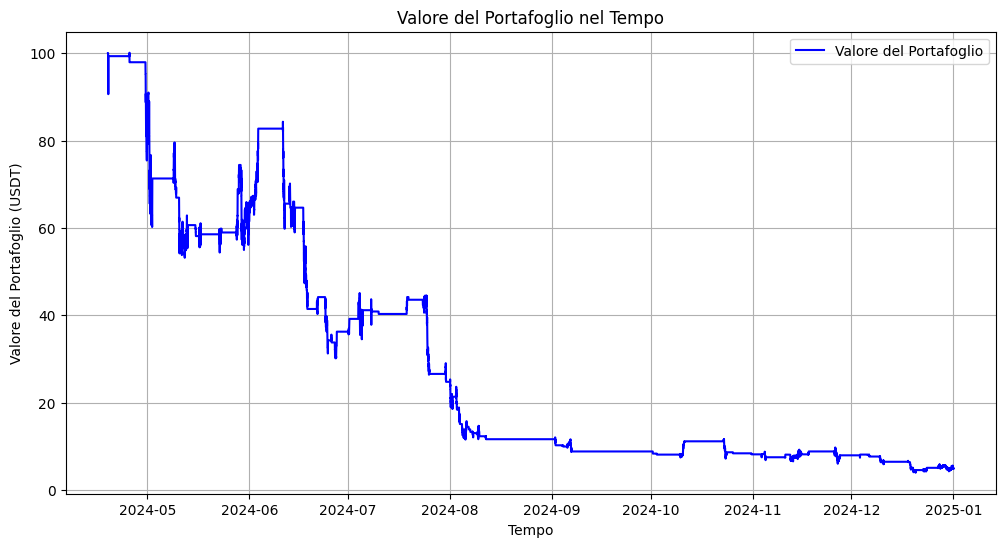

In [107]:
plot_portfolio(test_results)

### Ottimizzazione

In [108]:
# -----------------------------------------------
# FUNZIONI DI SUPPORTO
# -----------------------------------------------

def split_data(df, train_size=0.6, validation_size=0.2):
    """Divide i dati in train, validation e test mantenendo l'ordine temporale."""
    if train_size + validation_size >= 1:
        raise ValueError("La somma di train_size e validation_size deve essere minore di 1.")
    
    train_end = int(len(df) * train_size)
    val_end = train_end + int(len(df) * validation_size)
    train = df.iloc[:train_end]
    validation = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, validation, test

def calculate_metrics_2(results_df, initial_balance):
    """Calcola le metriche di performance base: ritorno totale e max drawdown."""
    total_return_factor = results_df['total_portfolio'].iloc[-1] / initial_balance
    peak = results_df['total_portfolio'].cummax()
    drawdown = (peak - results_df['total_portfolio']) / peak
    max_drawdown = drawdown.max()
    return total_return_factor, max_drawdown

def optimize_parameters(train_df, validation_df, initial_balance=100, patience=10, maxiter=1000, method='powell'):
    """Ottimizza i parametri sul train set e usa il validation set per selezionare i migliori parametri."""
    best_params = None
    best_val_score = float('-inf')
    patience_counter = 0
    iteration = 0

    def objective(params):
        nonlocal best_params, best_val_score, patience_counter, iteration
        iteration += 1

        # Converti i parametri in un dizionario
        params_dict = {
            'obi_threshold': params[0],
            'spread_threshold': params[1],
            'risk_per_trade': params[2],
            'leverage': int(params[3]),
            'stop_loss_pct': params[4],
            'take_profit_pct': params[5],
            'position_hold_bars': int(params[6])
        }

        # Calcolo score sul train set (per l'ottimizzazione)
        train_results, _ = backtest_strategy(train_df, params_dict, initial_balance)
        train_return_factor, train_drawdown = calculate_metrics_2(train_results, initial_balance)
        train_score = train_return_factor - train_drawdown

        # Calcolo score sul validation set (per il monitoraggio)
        val_results, _ = backtest_strategy(validation_df, params_dict, initial_balance)
        val_return_factor, val_drawdown = calculate_metrics_2(val_results, initial_balance)
        val_score = val_return_factor - val_drawdown

        # Stampa per debug
        print(f"\nIterazione {iteration}/{maxiter}:")
        print(f"Parametri: {params_dict}")
        print(f"Train Score: {train_score:.4f} (Return Factor: {train_return_factor:.4f}, Drawdown: {train_drawdown:.4f})")
        print(f"Validation Score: {val_score:.4f} (Return Factor: {val_return_factor:.4f}, Drawdown: {val_drawdown:.4f})")

        # Aggiorna i migliori parametri se il validation score migliora
        if val_score > best_val_score:
            best_val_score = val_score
            best_params = params_dict.copy()
            patience_counter = 0
            print(f"Nuovo miglior validation score: {best_val_score}")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping: nessun miglioramento sul validation set!")
            raise StopIteration

        # L'ottimizzazione massimizza il train_score
        return -train_score

    # Parametri iniziali e bounds
    initial_guess = [0.3, 999, 0.1, 10, 0.05, 0.01, 288]
    bounds = [
        (0.0, 1.0), (999, 999), (0.01, 1.0), (1, 100), (0.001, 1.0), (0.001, 1.0), (1, 999)
    ]

    # Esegui l'ottimizzazione
    try:
        minimize(objective, initial_guess, bounds=bounds, method=method, options={'maxiter': maxiter})
    except StopIteration:
        pass

    print(f"\nMigliori parametri trovati: {best_params}")
    print(f"Miglior validation score: {best_val_score:.4f}")
    return best_params

def calculate_performance_metrics(results_df, trades_df, initial_balance):
    """Calcola tutte le metriche di performance."""
    total_return_factor, max_drawdown = calculate_metrics_2(results_df, initial_balance)
    sharpe_ratio = results_df['returns'].mean() / results_df['returns'].std() * np.sqrt(252 * 288) if results_df['returns'].std() > 0 else 0
    if not trades_df.empty and 'pnl' in trades_df.columns:
        win_rate = (trades_df['pnl'] > 0).mean() * 100
        profit_factor = trades_df[trades_df['pnl'] > 0]['pnl'].sum() / abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if trades_df[trades_df['pnl'] < 0]['pnl'].sum() != 0 else float('inf')
    else:
        win_rate = 0
        profit_factor = 0  # O un altro valore significativo nel tuo contesto
    total_trades = len(trades_df)
    return {
        'Total Return Factor': total_return_factor,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown * 100,
        'Win Rate (%)': win_rate,
        'Profit Factor': profit_factor,
        'Total Trades': total_trades
    }

In [110]:
# --------------------------------------------------
# ESECUZIONE BACKTESTING
# --------------------------------------------------

# Parametri configurabili
train_size = 0.6  # Percentuale dati di train
validation_size = 0.2  # Percentuale dati di validation
initial_balance = 100
patience = 100
maxiter = 1000
method = 'TNC'  # method può essere nelder-mead, powell, L-BFGS-B ecc

# Dividi i dati
train_df, validation_df, test_df = split_data(btc_df, train_size=train_size, validation_size=validation_size)
print(f"Dati divisi: Train={len(train_df)}, Validation={len(validation_df)}, Test={len(test_df)}")

# Ottimizza i parametri
optimized_params = optimize_parameters(train_df, validation_df, initial_balance=initial_balance, patience=patience, maxiter=maxiter, method=method)
print("\nParametri ottimizzati:")
print(pd.Series(optimized_params).to_frame().T)

# Lista dei set da analizzare
sets = [
    ('Train', train_df),
    ('Validation', validation_df),
    ('Test', test_df)
]

# Esegui il backtest e visualizza i risultati per ogni set
for set_name, df in sets:
    # Esegui il backtest sul set corrente
    results, trades = backtest_strategy(df, optimized_params, initial_balance)
    
    # Calcola le metriche di performance
    performance = calculate_performance_metrics(results, trades, initial_balance)
    
    # Visualizza i risultati
    print(f"\nMetriche di performance sul {set_name} set:")
    print(pd.Series(performance).to_frame().T)
    print(f"\nTrades sul {set_name} set:")
    display(trades)
    print(f"\nEvoluzione del portafoglio sul {set_name} set:")
    display(results)

Dati divisi: Train=42773, Validation=14257, Test=14259


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_38984\2256648956.py:89: OptimizeWarning: Unknown solver options: maxiter
  minimize(objective, initial_guess, bounds=bounds, method=method, options={'maxiter': maxiter})



Iterazione 1/1000:
Parametri: {'obi_threshold': 0.3, 'spread_threshold': 999.0, 'risk_per_trade': 0.1, 'leverage': 10, 'stop_loss_pct': 0.05, 'take_profit_pct': 0.01, 'position_hold_bars': 288}
Train Score: -0.5627 (Return Factor: 0.4060, Drawdown: 0.9687)
Validation Score: 1.8372 (Return Factor: 2.2815, Drawdown: 0.4444)
Nuovo miglior validation score: 1.8371501088624507

Iterazione 2/1000:
Parametri: {'obi_threshold': 0.30000001, 'spread_threshold': 999.0, 'risk_per_trade': 0.1, 'leverage': 10, 'stop_loss_pct': 0.05, 'take_profit_pct': 0.01, 'position_hold_bars': 288}
Train Score: -0.5627 (Return Factor: 0.4060, Drawdown: 0.9687)
Validation Score: 1.8372 (Return Factor: 2.2815, Drawdown: 0.4444)
Patience: 1/100

Iterazione 3/1000:
Parametri: {'obi_threshold': 0.3, 'spread_threshold': 999.0, 'risk_per_trade': 0.10000001, 'leverage': 10, 'stop_loss_pct': 0.05, 'take_profit_pct': 0.01, 'position_hold_bars': 288}
Train Score: -0.5627 (Return Factor: 0.4060, Drawdown: 0.9687)
Validation 

,entry_time,exit_time,direction,size,entry_price,exit_price,pnl,commission,reason,entry_portfolio,exit_portfolio
0,2024-04-19 01:40:00,2024-04-19 03:10:00,1,0.016382,61041.76,61652.179866,9.798037,0.202000,take_profit,100.000000,113.623815
1,2024-04-25 13:20:00,2024-04-25 14:10:00,1,0.017356,63146.52,63777.987544,10.738456,0.221388,take_profit,109.598037,120.118999
2,2024-04-30 09:40:00,2024-05-01 07:05:00,1,0.019419,61855.68,58762.896586,-60.286860,0.228223,stop_loss,120.117297,54.246804
3,2024-05-01 07:10:00,2024-05-01 18:50:00,1,0.010184,58516.00,59101.162172,5.838670,0.120372,take_profit,59.590203,68.949588
4,2024-05-01 19:30:00,2024-05-01 21:20:00,1,0.011416,57207.38,57779.455924,6.399068,0.131926,take_profit,65.309692,72.761669
...,...,...,...,...,...,...,...,...,...,...,...
63,2024-09-04 01:05:00,2024-09-04 01:35:00,1,0.004581,56040.01,56600.412180,2.515612,0.051863,take_profit,25.674656,28.573738
64,2024-09-04 08:50:00,2024-09-04 14:50:00,1,0.004958,56749.27,57316.764807,2.757062,0.056841,take_profit,28.138919,31.373722
65,2024-09-05 15:35:00,2024-09-06 02:05:00,1,0.005488,56191.10,56753.013086,3.021686,0.062296,take_profit,30.839703,34.174825
66,2024-09-06 07:25:00,2024-09-06 10:20:00,1,0.006083,55568.00,56123.682063,3.311708,0.068275,take_profit,33.799709,37.193039



Evoluzione del portafoglio sul Train set:


,open,high,low,close,volume,notional_-5,notional_-4,notional_-3,notional_-2,notional_-1,...,spread,signal,portfolio,unrealized_pnl,total_portfolio,returns,position_size,position_value,pnl,commissions
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-19 00:00:00,63470.09,63470.09,63272.60,63283.05,171.66048,2.805868e+08,2.546757e+08,2.235747e+08,1.712686e+08,8.151701e+07,...,127.419294,0,100.000000,0.0,100.000000,0.0,0.0,0.0,0.0,0.0
2024-04-19 00:05:00,63283.05,63283.05,63072.99,63089.99,129.03663,2.979414e+08,2.626244e+08,2.317270e+08,1.866406e+08,8.880829e+07,...,-180.642663,0,100.000000,0.0,100.000000,0.0,0.0,0.0,0.0,0.0
2024-04-19 00:10:00,63090.00,63090.00,62912.64,62913.99,209.10677,3.093996e+08,2.624514e+08,2.300250e+08,1.892556e+08,8.843862e+07,...,-287.616125,0,100.000000,0.0,100.000000,0.0,0.0,0.0,0.0,0.0
2024-04-19 00:15:00,62914.00,63073.00,62913.99,63068.00,123.27576,3.168050e+08,2.667421e+08,2.336174e+08,1.932235e+08,9.231861e+07,...,-275.645466,0,100.000000,0.0,100.000000,0.0,0.0,0.0,0.0,0.0
2024-04-19 00:20:00,63068.00,63106.57,62990.95,62992.11,56.42708,3.300506e+08,2.808887e+08,2.477095e+08,2.006171e+08,1.016706e+08,...,-356.843069,0,100.000000,0.0,100.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-19 20:50:00,63100.00,63127.60,63042.76,63102.00,85.10828,4.274929e+08,3.866913e+08,3.315609e+08,2.512010e+08,1.465669e+08,...,-1171.730502,0,40.599297,0.0,40.599297,0.0,0.0,0.0,0.0,0.0
2024-09-19 20:55:00,63102.00,63102.00,62961.20,63016.74,111.37131,4.216169e+08,3.807720e+08,3.263471e+08,2.455002e+08,1.411551e+08,...,-1128.273476,0,40.599297,0.0,40.599297,0.0,0.0,0.0,0.0,0.0
2024-09-19 21:00:00,63016.75,63048.00,62950.00,62954.29,67.97360,4.161250e+08,3.774782e+08,3.209571e+08,2.501145e+08,1.408147e+08,...,-1168.201127,0,40.599297,0.0,40.599297,0.0,0.0,0.0,0.0,0.0



Metriche di performance sul Validation set:
   Total Return Factor  Sharpe Ratio  Max Drawdown (%)  Win Rate (%)  \
0             2.281524      2.798627         44.436664         100.0   

   Profit Factor  Total Trades  
0            inf           9.0  

Trades sul Validation set:


,entry_time,exit_time,direction,size,entry_price,exit_price,pnl,commission,reason,entry_portfolio,exit_portfolio
0,2024-10-01 14:25:00,2024-10-07 00:45:00,1,0.015921,62808.76,63436.849931,9.798037,0.202000,take_profit,100.000000,112.343632
1,2024-10-09 20:50:00,2024-10-10 06:30:00,1,0.018119,60488.01,61092.892345,10.738456,0.221388,take_profit,109.598037,120.467650
2,2024-10-10 09:30:00,2024-10-11 12:30:00,1,0.019741,60848.00,61456.482259,11.769137,0.242637,take_profit,120.117297,131.058900
3,2024-10-23 03:30:00,2024-10-24 13:10:00,1,0.019657,66970.00,67639.702486,12.898744,0.265925,take_profit,131.646200,144.482462
4,2024-10-25 23:15:00,2024-10-26 02:45:00,1,0.021767,66284.87,66947.721160,14.136770,0.291449,take_profit,144.281651,159.515286
5,2024-10-31 14:00:00,2024-11-01 14:30:00,1,0.022310,70878.00,71586.782631,15.493622,0.319422,take_profit,158.129858,171.352287
6,2024-11-03 14:30:00,2024-11-03 19:40:00,1,0.025488,67996.01,68675.972624,16.980706,0.350081,take_profit,173.307220,189.374527
7,2024-11-04 14:50:00,2024-11-05 07:40:00,1,0.027824,68266.00,68948.662534,18.610520,0.383681,take_profit,189.941312,207.702485
8,2024-11-10 21:00:00,2024-11-10 21:30:00,1,0.026404,78839.99,79628.392827,20.396765,0.420507,take_profit,208.171949,227.611684



Evoluzione del portafoglio sul Validation set:


,open,high,low,close,volume,notional_-5,notional_-4,notional_-3,notional_-2,notional_-1,...,spread,signal,portfolio,unrealized_pnl,total_portfolio,returns,position_size,position_value,pnl,commissions
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-19 21:20:00,63052.01,63052.01,62992.35,62992.35,22.06498,4.275623e+08,3.839368e+08,3.282345e+08,2.479799e+08,1.318944e+08,...,-984.335899,0,100.00000,0.0,100.00000,0.0,0.0,0.0,0.0,0.0
2024-09-19 21:25:00,62992.36,62992.36,62962.01,62962.01,20.10444,4.331933e+08,3.945418e+08,3.407876e+08,2.667853e+08,1.403544e+08,...,-1140.228174,0,100.00000,0.0,100.00000,0.0,0.0,0.0,0.0,0.0
2024-09-19 21:30:00,62962.01,63100.00,62960.22,62987.49,40.29765,4.404319e+08,4.003435e+08,3.488362e+08,2.748455e+08,1.465675e+08,...,-1273.980080,0,100.00000,0.0,100.00000,0.0,0.0,0.0,0.0,0.0
2024-09-19 21:35:00,62987.50,62987.50,62898.20,62898.20,41.71203,4.359797e+08,3.970174e+08,3.435310e+08,2.691255e+08,1.430631e+08,...,-1175.547015,0,100.00000,0.0,100.00000,0.0,0.0,0.0,0.0,0.0
2024-09-19 21:40:00,62898.21,62978.00,62898.21,62935.01,54.95866,4.409329e+08,3.997574e+08,3.523403e+08,2.761154e+08,1.478854e+08,...,-1332.694907,0,100.00000,0.0,100.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-11 06:15:00,80872.00,80897.02,80695.99,80777.98,91.14929,5.274256e+08,4.103969e+08,3.263731e+08,2.377829e+08,1.241514e+08,...,-170.638077,0,228.15237,0.0,228.15237,0.0,0.0,0.0,0.0,0.0
2024-11-11 06:20:00,80777.99,80900.00,80736.00,80896.18,98.63105,5.415651e+08,4.256841e+08,3.272735e+08,2.444936e+08,1.245587e+08,...,-248.076560,0,228.15237,0.0,228.15237,0.0,0.0,0.0,0.0,0.0
2024-11-11 06:25:00,80896.18,81184.13,80896.18,81100.98,169.03579,5.264811e+08,4.078170e+08,3.169056e+08,2.350422e+08,1.151580e+08,...,-58.128864,0,228.15237,0.0,228.15237,0.0,0.0,0.0,0.0,0.0



Metriche di performance sul Test set:
   Total Return Factor  Sharpe Ratio  Max Drawdown (%)  Win Rate (%)  \
0             2.386584      2.168431         75.585724     89.285714   

   Profit Factor  Total Trades  
0       1.525498          28.0  

Trades sul Test set:


,entry_time,exit_time,direction,size,entry_price,exit_price,pnl,commission,reason,entry_portfolio,exit_portfolio
0,2024-11-12 09:25:00,2024-11-12 19:25:00,1,0.011295,88532.00,89417.323286,9.798037,0.202000,take_profit,100.000000,110.146654
1,2024-11-13 02:25:00,2024-11-13 13:30:00,1,0.012523,87516.01,88391.173349,10.738456,0.221388,take_profit,109.598037,122.055198
2,2024-11-13 21:05:00,2024-11-13 22:20:00,1,0.013547,88667.15,89553.824791,11.769137,0.242637,take_profit,120.117297,132.170550
3,2024-11-14 07:05:00,2024-11-14 07:45:00,1,0.014722,89419.99,90314.193219,12.898744,0.265925,take_profit,131.646200,145.267594
4,2024-11-14 14:50:00,2024-11-15 12:10:00,1,0.016177,89187.00,90078.873311,14.136770,0.291449,take_profit,144.281651,167.831179
5,2024-11-15 14:30:00,2024-11-15 14:45:00,1,0.017790,88886.64,89775.509699,15.493622,0.319422,take_profit,158.129858,174.489644
6,2024-11-15 14:55:00,2024-11-15 19:35:00,1,0.019449,89107.98,89999.063108,16.980706,0.350081,take_profit,173.307220,193.634831
7,2024-11-17 21:15:00,2024-11-18 01:15:00,1,0.021262,89332.01,90225.333416,18.610520,0.383681,take_profit,189.941312,208.800288
8,2024-11-25 19:25:00,2024-11-27 16:30:00,1,0.021893,95084.52,96035.368730,20.396765,0.420507,take_profit,208.171949,230.004512
9,2024-12-03 13:35:00,2024-12-03 15:00:00,1,0.024126,94568.38,95514.067310,22.354454,0.460868,take_profit,228.152370,251.161156



Evoluzione del portafoglio sul Test set:


,open,high,low,close,volume,notional_-5,notional_-4,notional_-3,notional_-2,notional_-1,...,spread,signal,portfolio,unrealized_pnl,total_portfolio,returns,position_size,position_value,pnl,commissions
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-11-11 06:40:00,81102.01,81103.29,80791.65,80792.08,302.65550,5.132868e+08,3.886454e+08,3.109343e+08,2.359208e+08,1.121584e+08,...,76.577819,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.00000,0.000000
2024-11-11 06:45:00,80792.07,80899.23,80780.00,80865.75,232.25488,5.352775e+08,4.233365e+08,3.278574e+08,2.449871e+08,1.307436e+08,...,-191.459367,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.00000,0.000000
2024-11-11 06:50:00,80865.74,80950.00,80835.99,80908.06,107.05633,5.334759e+08,4.152547e+08,3.310504e+08,2.464959e+08,1.312719e+08,...,-226.472646,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.00000,0.000000
2024-11-11 06:55:00,80908.06,80950.00,80834.01,80900.68,65.77079,5.270047e+08,4.079304e+08,3.141913e+08,2.370168e+08,1.197013e+08,...,-90.359358,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.00000,0.000000
2024-11-11 07:00:00,80900.68,80980.00,80824.44,80835.94,128.41044,5.283176e+08,4.089560e+08,3.223863e+08,2.383083e+08,1.293741e+08,...,-247.747909,0,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:35:00,93546.03,93546.03,93456.02,93464.26,37.27614,8.928054e+08,7.590884e+08,4.991608e+08,3.300921e+08,1.791560e+08,...,-854.616291,0,242.850254,-6.607212,236.243043,-0.008907,0.0,0.0,0.00000,0.000000
2024-12-31 23:40:00,93464.27,93504.00,93456.00,93490.87,23.44102,8.939847e+08,7.628307e+08,5.104306e+08,3.353413e+08,1.824000e+08,...,-949.233298,0,242.850254,-5.916294,236.933961,0.002925,0.0,0.0,0.00000,0.000000
2024-12-31 23:45:00,93490.86,93544.50,93484.30,93544.49,23.00051,8.940680e+08,7.583909e+08,5.041382e+08,3.324905e+08,1.801727e+08,...,-987.601372,0,242.850254,-4.524072,238.326182,0.005876,0.0,0.0,0.00000,0.000000


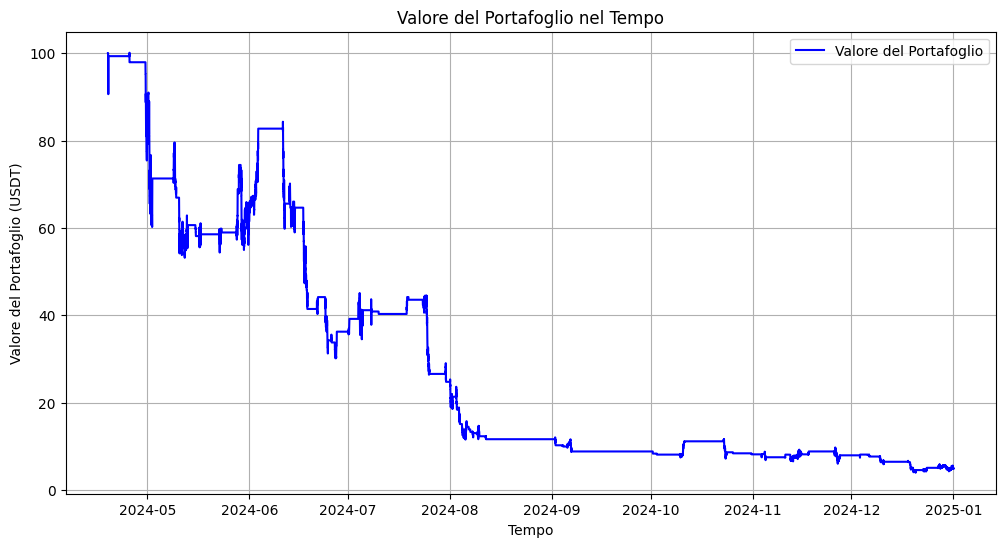

In [111]:
plot_portfolio(test_results)